# DNA RL: Crossover based optimization algorithm

Importing Libraries

In [1]:
import dna_env
import a2c
import torch
import variable as v
from tqdm import tqdm
from train_session import TrainSession
import matplotlib.pyplot as plt
from copy import deepcopy

Initializing Environment

In [2]:
sequence_length = 36
render = True
state_representation = 'latent'
use_test_set = False
action_constraints = {'co_length': (-1, 36), 
                      'opt_start_point': (-1, 36),
                      'co_start_point': (-1, 36)}
early_stop_reward = {'reward_low_threshold': -1,
                     'reward_high_threshold': .9, 
                     'patience': 200}
env = dna_env.DnaRLEnv(action_constraints=action_constraints, 
                       early_stop_reward=early_stop_reward, 
                       use_test_set=use_test_set,
                       sequence_length=sequence_length, 
                       state_representation=state_representation)
env.reset()
train_session = None

In [3]:
seed = 24
state_dim = env.get_state_dim()
action_dim = env.get_action_dim()
print(f"state dim: {state_dim}")
print(f"action dim: {action_dim}")

state dim: (400,)
action dim: (3, 36)


Creating our agent

In [4]:
critic_init = {
    'seed': seed,
    'action_dim': action_dim[0],
    'state_representation': state_representation,
    'network': {
        'i_size': state_dim[0],
        'l1_size': 200,
        'l2_size': 50,
               },
    'optimizer': {
        'lr': 1e-3
    }
}
actor_init = {
    'entropy_learning_rate': .05,
    'seed': seed,
    'action_dim': action_dim[0],
    'state_representation': state_representation,
    'network': {
        'i_size': state_dim[0], 
        'l1_size': 200,
        'hidden_size': 75,
        'o_size': sequence_length
               },
    'optimizer': {
        'lr': 1e-3
    }
}
a2c_init = {
    'actor_type': 'actor_rnn',
    'seed': seed,
    'discount_factor': 1.0, 
    'state_dim': state_dim, 
    'action_space': 3, 
    'actor': actor_init, 
    'critic': critic_init
}

In [5]:
if not train_session:
    print('Train Session reset')
    train_session = TrainSession({}, env, seed)

Train Session reset


In [6]:
agents_created = {
    'a2c_agent': a2c.A2C(a2c_init)
}
manual_agent_names = train_session.append_agents(agents_created)

In [8]:
all_agent_names = train_session.agents.keys()
s = '\n- '.join(all_agent_names)
print(f"All Agents: \n- {s}")

All Agents: 
- a2c_agent


In [9]:
#train_session.load_model('a2c_agent', suffix='0707')

In [10]:
n_episode = 800
t_max_per_episode = 100
graphical = False

In [11]:
train_session.train(n_episode=n_episode, t_max_per_episode=t_max_per_episode,
                    graphical=graphical, agent_subset=manual_agent_names)

100%|██████████| 800/800 [1:00:04<00:00,  4.51s/it]


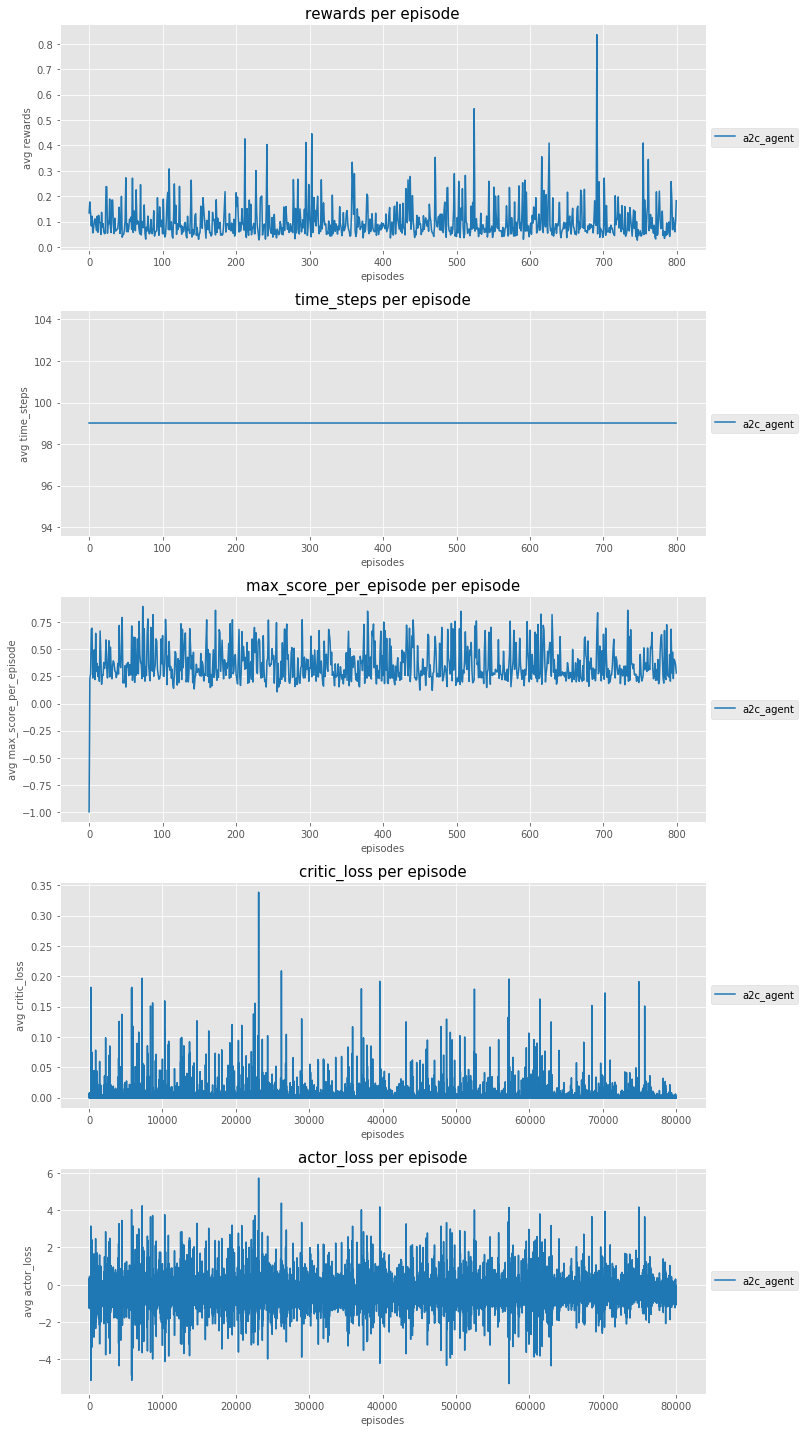

In [12]:
train_session.plot_results(window=1, agent_subset=manual_agent_names)

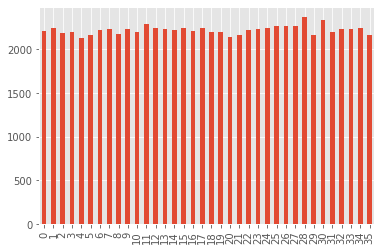

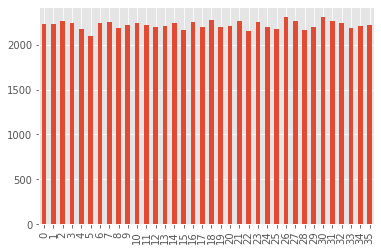

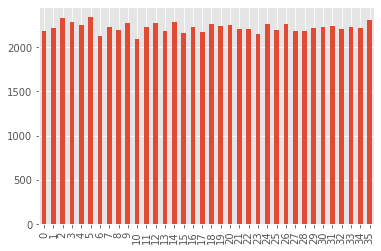

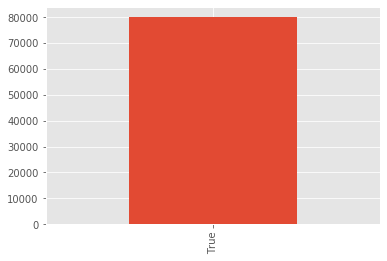

<Figure size 432x288 with 0 Axes>

In [13]:
train_session.env.actions_analysis()

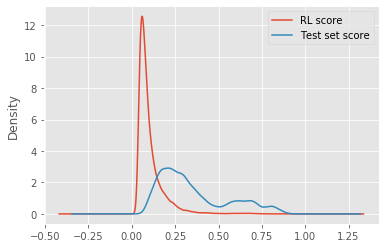

In [15]:
train_session.plot_density()

In [35]:
import pandas as pd

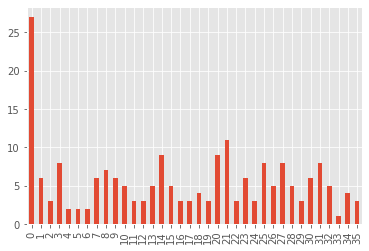

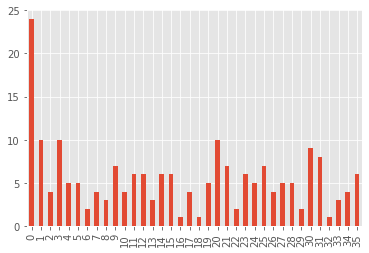

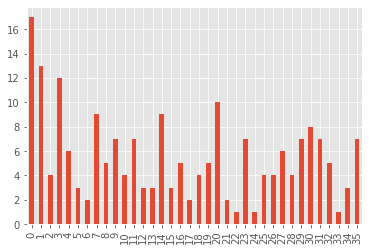

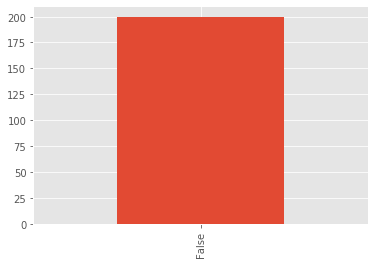

<Figure size 432x288 with 0 Axes>

In [38]:
actions_history = pd.DataFrame(train_session.env.actions_history)

for col in actions_history.columns:
    actions_history[col].value_counts(sort=False).plot(kind='bar')
    plt.figure()

In [36]:
train_session.save_model(suffix='0708')

In [17]:
max(train_session.reward_per_time_step["a2c_agent"])

0.8542967438697815

In [21]:
import numpy as np

In [25]:
a = np.array(train_session.rewards_per_episode["a2c_agent"])[1:]

In [27]:
a[a <= 0]

array([-9.90835508, -9.94088941])

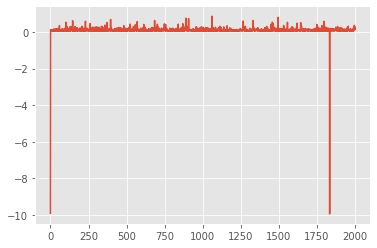

In [26]:
plt.plot(range(len(a)), a)

In [29]:
b = np.array(train_session.reward_per_time_step["a2c_agent"])[1:]

In [33]:
b[b >= 0].shape[0] - b[b <= 0].shape[0]

1959

(200979,)

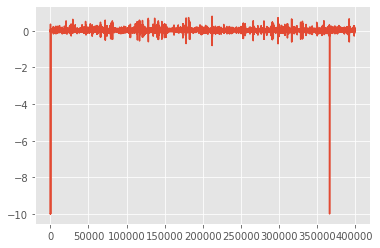

In [34]:
plt.plot(range(len(b)), b)

In [27]:
np.ma.apply_along_axis(np.ma.masked_not_equal(train_session.reward_per_time_step["a2c_agent"], -1.0))

TypeError: apply_along_axis() missing 2 required positional arguments: 'axis' and 'arr'

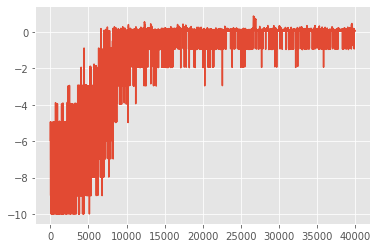

In [10]:
import numpy as np
train_session.reward_per_time_step["a2c_agent"] = np.ma.masked_not_equal(train_session.reward_per_time_step["a2c_agent"], -1.0)
series_mvg = utils.rolling_window(train_session.reward_per_time_step["a2c_agent"], window=10)
series_mvg_avg = np.mean(series_mvg, axis=1)
plt.plot(range(len(series_mvg_avg)), series_mvg_avg)

In [37]:
train_session.agents["a2c_agent"].critic(torch.rand(1, 400).cuda())

tensor([[-0.0450]], device='cuda:0', grad_fn=<AddmmBackward>)

In [25]:
state = env.reset()

In [13]:
(1, ) + state.shape

(1, 400)

In [10]:
a = torch.tensor([11, 23,  3], device=v.device)

In [13]:
a.cpu().numpy()

array([11, 23,  3])

In [17]:
a.prod()

tensor(759, device='cuda:0')

In [10]:
import utils

In [16]:
utils.to_tensor([[float(3)]])


tensor([[3.]], device='cuda:0')

In [61]:
torch.save(train_session.agents["a2c_agent"].critic.state_dict(), "/home/benoit/Documents/work/RL_DNA/saved_model/a2c_agent_critic_1.pth")

In [62]:
torch.save(train_session.agents["a2c_agent"].actor.state_dict(), "/home/benoit/Documents/work/RL_DNA/saved_model/a2c_agent_actor_1.pth")

In [36]:
max([.9, .8])

0.9